In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
from sklearn import metrics

# Define the neural network architecture
class ParallelNN(nn.Module):
    def __init__(self, input1_size, input2_size, hidden_size, num_classes):
        super(ParallelNN, self).__init__()

        # Define the first pipeline
        self.pipeline1 = nn.Sequential(
                nn.Linear(input1_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
            )

        # Define the second pipeline
        self.pipeline2 = nn.Sequential(
                nn.Linear(input2_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
            )

        # Define the final classification layer
        self.classification = nn.Sequential(
            nn.Linear(2 * hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x1, x2):
        out1 = self.pipeline1(x1)
        out2 = self.pipeline2(x2)

        # Concatenate the outputs
        merged_out = torch.cat((out1, out2), dim=1)

        # Apply the final classification layer
        final_out = self.classification(merged_out)
        return final_out
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.001)


# Define the input sizes, hidden size, and number of classes
#input1_size = 10  # Change this to match the number of features in your first dataset
#input2_size = 8   # Change this to match the number of features in your second dataset
#hidden_size = 64
#num_classes = 3   # Change this to match the number of classes in your classification task

# Initialize the model
#model = ParallelNN(input1_size, input2_size, hidden_size, num_classes)

# Define your loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [2]:
# Load the data from a CSV file
NMR_csv_name = '../data/PD_Serum_Metabolomics_Final_NMR.csv'
MS_csv_name = '../data/preprocessed_data_PD.csv'

NMR_data = pd.read_csv(NMR_csv_name)
MS_data = pd.read_csv(MS_csv_name)

# Labels are first column of MS data
# Remove 305h row from MS data, because it is missing from NMR data
data1 = torch.tensor(NMR_data.values, dtype=torch.float32).to(device)
data2 = torch.tensor(MS_data.drop(index=305).iloc[:, 1:].values, dtype=torch.float32).to(device)
labels = torch.tensor(MS_data.drop(index=305).iloc[:, 0].values, dtype=torch.long).to(device)

# Normalize the data
row_normalization = False
if row_normalization:
    # Divide each row by its sum
    # data1 = data1 / data1.sum(dim=1, keepdim=True)
    # data2 = data2 / data2.sum(dim=1, keepdim=True)
    data1 = (data1 - data1.mean(dim=1, keepdim=True)) / data1.std(dim=1, keepdim=True)
    data2 = (data2 - data2.mean(dim=1, keepdim=True)) / data2.std(dim=1, keepdim=True)
data1 = (data1 - data1.mean(dim=0, keepdim=True)) / data1.std(dim=0, keepdim=True)
data2 = (data2 - data2.mean(dim=0, keepdim=True)) / data2.std(dim=0, keepdim=True)

binary = True
num_classes = 2 if binary else 3
if binary:
    labels[labels == 2] = 1

# Define model, loss function, and optimizer
model = ParallelNN(input1_size=data1.shape[1], input2_size=data2.shape[1], hidden_size=32, num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
k_folds = 5

# Prepare data loaders
dataset = TensorDataset(data1, data2, labels)
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=1000)
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

# Training loop
def train(model, dataloader, criterion, optimizer, best_loss):
    pbar = tqdm(dataloader)
    correct = 0
    running_loss = 0
    

    for (data1, data2, labels) in pbar:
        model.train()

        data1, data2, labels = data1, data2, labels

        optimizer.zero_grad()
        outputs = model(data1, data2)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * data1.size(0)

        loss.backward()
        optimizer.step()

        # correct += (outputs.argmax(dim=1) == labels).float().sum()
        correct += (outputs.argmax(dim=1) == labels).float().sum().cpu().numpy()
        accuracy = correct / 1000  # Used in sampling

         
        pbar.set_description(f"Loss: {running_loss / 1000:.4f}, Accuracy: {accuracy:.4f}")

    # Validation loop
    val_loss = 0
    val_accuracy = 0
    model.eval()

    with torch.no_grad():
        for (data1_v, data2_v, labels_v) in val_loader:

            outputs = model(data1_v, data2_v)
            loss = criterion(outputs, labels_v)
            val_loss += loss.item() * data1_v.size(0)
            val_accuracy += (outputs.argmax(dim=1) == labels_v).float().sum()

    val_loss /= 65
    val_accuracy = val_accuracy.cpu().numpy() / 65  # Move before using

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_two_pipeline_PD.pth')

    torch.save(model.state_dict(), 'latest_model_two_pipeline_PD.pth')

    return val_loss, val_accuracy, running_loss / 1000, accuracy
        

Epoch 1/30


Loss: 0.6157, Accuracy: 0.6670: 100%|██████████| 32/32 [00:02<00:00, 13.85it/s]


Validation Loss: 0.6647, Validation Accuracy: 0.6308
Epoch 2/30


Loss: 0.3985, Accuracy: 0.8520: 100%|██████████| 32/32 [00:01<00:00, 27.04it/s]


Validation Loss: 0.5432, Validation Accuracy: 0.7231
Epoch 3/30


Loss: 0.2506, Accuracy: 0.9210: 100%|██████████| 32/32 [00:01<00:00, 23.64it/s]


Validation Loss: 0.5880, Validation Accuracy: 0.7385
Epoch 4/30


Loss: 0.1911, Accuracy: 0.9350: 100%|██████████| 32/32 [00:01<00:00, 19.06it/s]


Validation Loss: 0.5958, Validation Accuracy: 0.7385
Epoch 5/30


Loss: 0.1343, Accuracy: 0.9590: 100%|██████████| 32/32 [00:01<00:00, 24.29it/s]


Validation Loss: 0.6849, Validation Accuracy: 0.7077
Epoch 6/30


Loss: 0.0887, Accuracy: 0.9750: 100%|██████████| 32/32 [00:01<00:00, 22.14it/s]


Validation Loss: 0.5944, Validation Accuracy: 0.7385
Epoch 7/30


Loss: 0.0675, Accuracy: 0.9850: 100%|██████████| 32/32 [00:01<00:00, 23.10it/s]


Validation Loss: 0.7439, Validation Accuracy: 0.6615
Epoch 8/30


Loss: 0.0737, Accuracy: 0.9780: 100%|██████████| 32/32 [00:01<00:00, 27.23it/s]


Validation Loss: 0.8113, Validation Accuracy: 0.6154
Epoch 9/30


Loss: 0.0797, Accuracy: 0.9740: 100%|██████████| 32/32 [00:01<00:00, 22.40it/s]


Validation Loss: 0.7467, Validation Accuracy: 0.7077
Epoch 10/30


Loss: 0.1061, Accuracy: 0.9630: 100%|██████████| 32/32 [00:01<00:00, 27.85it/s]


Validation Loss: 0.8816, Validation Accuracy: 0.7077
Epoch 11/30


Loss: 0.0706, Accuracy: 0.9750: 100%|██████████| 32/32 [00:01<00:00, 22.22it/s]


Validation Loss: 0.6446, Validation Accuracy: 0.7231
Epoch 12/30


Loss: 0.0529, Accuracy: 0.9850: 100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


Validation Loss: 0.5627, Validation Accuracy: 0.7538
Epoch 13/30


Loss: 0.0454, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 24.20it/s]


Validation Loss: 0.6301, Validation Accuracy: 0.7231
Epoch 14/30


Loss: 0.0343, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


Validation Loss: 0.5991, Validation Accuracy: 0.7385
Epoch 15/30


Loss: 0.0309, Accuracy: 0.9970: 100%|██████████| 32/32 [00:01<00:00, 19.15it/s]


Validation Loss: 0.5859, Validation Accuracy: 0.7231
Epoch 16/30


Loss: 0.0257, Accuracy: 0.9970: 100%|██████████| 32/32 [00:01<00:00, 24.73it/s]


Validation Loss: 0.6024, Validation Accuracy: 0.7077
Epoch 17/30


Loss: 0.0224, Accuracy: 0.9990: 100%|██████████| 32/32 [00:01<00:00, 25.52it/s]


Validation Loss: 0.6057, Validation Accuracy: 0.7231
Epoch 18/30


Loss: 0.0288, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 23.37it/s]


Validation Loss: 0.5888, Validation Accuracy: 0.7385
Epoch 19/30


Loss: 0.0295, Accuracy: 0.9930: 100%|██████████| 32/32 [00:01<00:00, 21.17it/s]


Validation Loss: 0.6313, Validation Accuracy: 0.7385
Epoch 20/30


Loss: 0.0216, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 21.79it/s]


Validation Loss: 0.5699, Validation Accuracy: 0.7846
Epoch 21/30


Loss: 0.0160, Accuracy: 0.9990: 100%|██████████| 32/32 [00:01<00:00, 27.05it/s]


Validation Loss: 0.5569, Validation Accuracy: 0.7846
Epoch 22/30


Loss: 0.0247, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 21.14it/s]


Validation Loss: 0.5874, Validation Accuracy: 0.7385
Epoch 23/30


Loss: 0.0237, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 23.02it/s]


Validation Loss: 0.6076, Validation Accuracy: 0.7385
Epoch 24/30


Loss: 0.0188, Accuracy: 0.9980: 100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


Validation Loss: 0.6218, Validation Accuracy: 0.7538
Epoch 25/30


Loss: 0.0333, Accuracy: 0.9920: 100%|██████████| 32/32 [00:01<00:00, 23.39it/s]


Validation Loss: 0.6083, Validation Accuracy: 0.7385
Epoch 26/30


Loss: 0.0182, Accuracy: 1.0000: 100%|██████████| 32/32 [00:01<00:00, 20.92it/s]


Validation Loss: 0.5479, Validation Accuracy: 0.7692
Epoch 27/30


Loss: 0.0239, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 18.35it/s]


Validation Loss: 0.5355, Validation Accuracy: 0.7538
Epoch 28/30


Loss: 0.0209, Accuracy: 0.9980: 100%|██████████| 32/32 [00:01<00:00, 23.26it/s]


Validation Loss: 0.6082, Validation Accuracy: 0.7692
Epoch 29/30


Loss: 0.0184, Accuracy: 0.9970: 100%|██████████| 32/32 [00:01<00:00, 24.98it/s]


Validation Loss: 0.6033, Validation Accuracy: 0.7538
Epoch 30/30


Loss: 0.0216, Accuracy: 0.9980: 100%|██████████| 32/32 [00:01<00:00, 21.85it/s]


Validation Loss: 0.5893, Validation Accuracy: 0.7538
Finished training
Best cutoff threshold:  0.824192


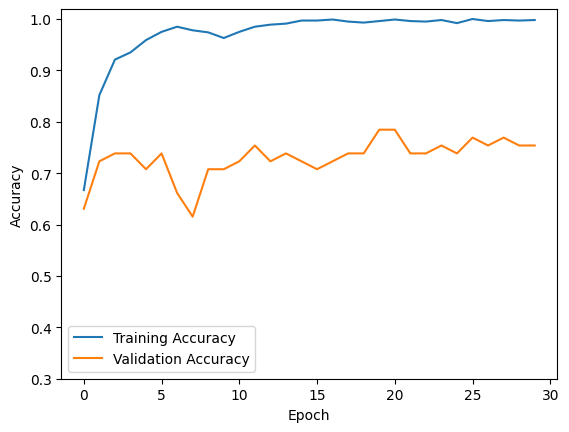

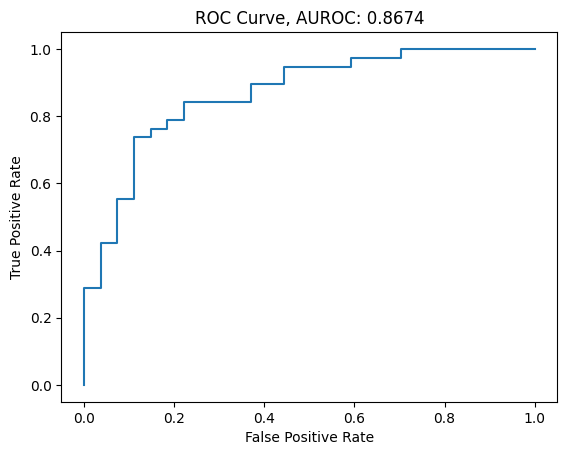

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Main function
def main():
    num_epochs = 30

    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        val_loss, val_accuracy, loss, accuracy = train(model, train_loader, criterion, optimizer, best_loss)
        scheduler.step()
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        accuracy_list.append(accuracy)
        loss_list.append(loss)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)

        best_loss = min(best_loss, val_loss)

    print("Finished training")

    binary_string = 'binary' if binary else 'multiclass'
    row_norm_string = 'row_norm' if row_normalization else 'no_row_norm'

    # Plot the training and validation loss
    plt.figure()
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yticks([i/10 for i in range(0, 20, 2)])
    plt.legend()
    plt.savefig(f"../Results_PD/loss_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    plt.clf()
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.yticks([i/10 for i in range(3, 11, 1)])
    plt.legend()
    plt.savefig(f"../Results_PD/accuracy_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Load the best model
    model.load_state_dict(torch.load('best_model_two_pipeline_PD.pth'))

    model.eval()
    y_pred = []
    y_true = []
    y_pred_prob = pd.DataFrame()

    with torch.no_grad():
        for (data1, data2, labels) in val_loader:
            data1, data2, labels = data1, data2, labels

            outputs = model(data1, data2).cpu()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
            y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(f"../Results_PD/confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")


    if binary:
        # Plot ROC curve with thresholds from 0.1 to 0.9
        plt.clf()
        # Calculate the AUROC score
        fpr, tpr, thresholds = roc_curve(np.array(y_true), y_pred_prob[1])
        print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(np.array(y_true), y_pred_prob[1])))
        plt.savefig(f"../Results_PD/roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    return roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])

if __name__ == "__main__":
    main()